In [248]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
# sys.path.append('/beegfs/desy/user/akorol/projects/point-cloud-diffusion/')

/tmp/ipykernel_60853/2900625769.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [249]:
from utils.plotting import *
from utils.plotting import cfg as cfg_plt
import utils.plotting as plotting

import numpy as np
import h5py
import matplotlib.pyplot as plt
import importlib

## Calculate num points in the point clouds, and occupancy

In [250]:
## NEEDS TO BE THE x36 POINT CLOUD / SAME AS TRAINING DATA

path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/10-90GeV_x36_grid_regular_float32.hdf5' # real point clouds 
real_showers = h5py.File(path, 'r')['events'][:]
real_showers[:, -1] = real_showers[:, -1] * 1000   # GeV to MeV

print(len(real_showers))

# only necessary if z axis of data not in absolute coordiantes, but in layer coordinates
# pos = np.linspace(0, 30, 31)
# for i in tqdm(range(30)):
#     idx = np.where((real_showers[:, 1] > pos[i]) & (real_showers[:, 1] < pos[i+1]))
#     real_showers[:, 1][idx] = layer_bottom_pos[i] + cell_thickness/2

40000


In [ ]:
# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_10-90GeV_with_flow_corrections_quadratic.npy')
# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_10-90GeV_with_flow_corrections_quadratic_batch.npy') # generated point clouds with CaloClouds

# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_10-90GeV_40k.npy')
#fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_10-90GeV_40k.npy')

# for n hits calibration (n_scaling=False)
fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k.npy')  # seed 1234  # new flow: 220714_cog_e_layer_ShowerFlow_best
fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k.npy')  # seed 1234 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k.npy')  # seed 1234 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# fake_showers[:, -1] = fake_showers[:, -1] / 1000
print(fake_showers.shape)


In [ ]:
n = 40000
importlib.reload(plotting)

events = plotting.get_projections(real_showers[:n], MAP, layer_bottom_pos)       # get projection of a point clouds to the detector grid
events_fake = plotting.get_projections(fake_showers[:n], MAP, layer_bottom_pos)  # get projection of a point clouds to the detector grid

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 40000/40000 [02:39<00:00, 251.10it/s]


In [ ]:
importlib.reload(plotting)

_, occ_real, _, _, _, _, _, _, _ = plotting.get_features(events)      # get event level features
_, occ_fake, _, _, _, _, _, _, _ = plotting.get_features(events_fake) # get event level features

 93%|█████████▎| 28/30 [00:00<00:00, 279.29it/s]

100%|██████████| 40000/40000 [01:45<00:00, 377.69it/s]


In [ ]:
num_hits_real = (real_showers[:, -1, :] > 0).sum(axis=1)  # get num points in the point clouds
num_hits_fakel = (fake_showers[:, -1, :] > 0).sum(axis=1) # get num points in the point clouds

In [ ]:
# np.save('occ_real.npy', occ_real)
# np.save('num_hits_real.npy', num_hits_real)

# np.save('occ_fake.npy', occ_fake)
# np.save('num_hits_fakel.npy', num_hits_fakel)



In [ ]:
# occ_real = np.load('occ_real.npy')
# num_hits_real = np.load('num_hits_real.npy')

# occ_fake = np.load('occ_fake.npy')
# num_hits_fakel = np.load('num_hits_fakel.npy')

In [322]:
coef = np.polyfit(num_hits_real, occ_real, 3)
poly1d_fn = np.poly1d(coef)

coef_2 = np.polyfit(occ_fake, num_hits_fakel, 3)
poly1d_fn_2 = np.poly1d(coef_2) 

In [323]:
poly1d_fn   # coef_real

poly1d([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])

In [324]:
poly1d_fn_2   # coef_fake

poly1d([-9.02997505e-07,  2.82747963e-03,  1.01417267e+00,  1.64829018e+02])

In [325]:
poly1d_fn_2(poly1d_fn(3000)) / 3000

0.7192100871369204

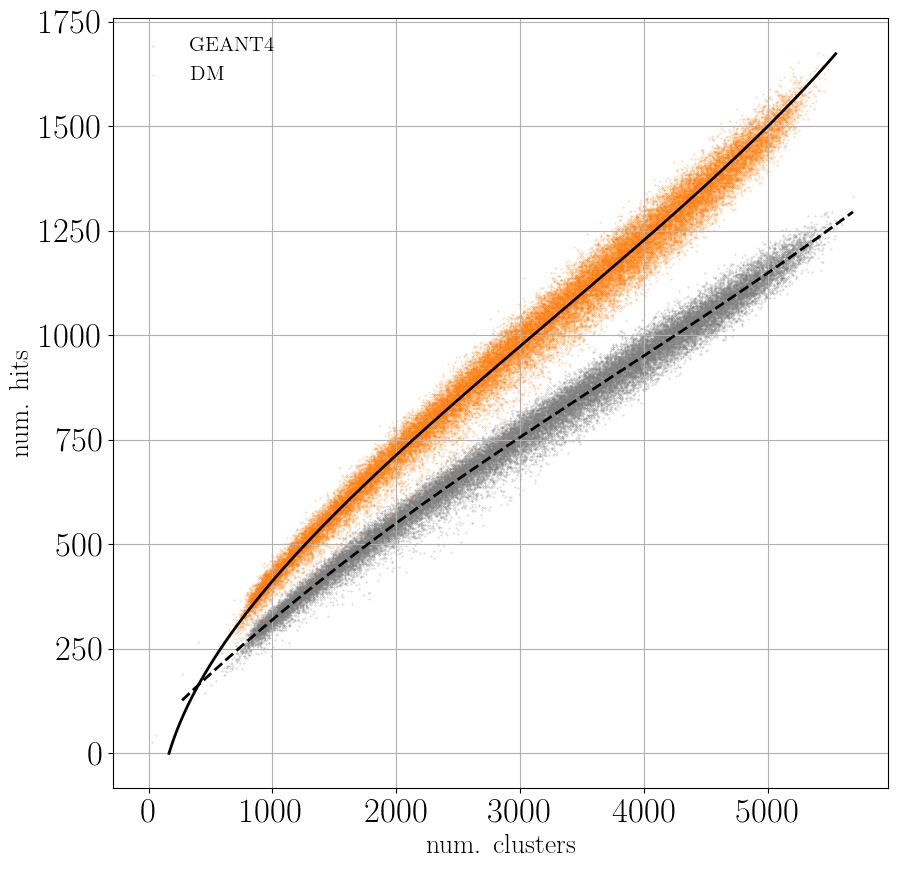

In [326]:
plt.figure(figsize=(10, 10))
plt.scatter(num_hits_real, occ_real, s=0.1, alpha=0.5, label='GEANT4', color='grey')
plt.plot(np.arange(num_hits_real.min(), num_hits_real.max()), poly1d_fn(np.arange(num_hits_real.min(), num_hits_real.max())), '--k', lw=2)
plt.scatter(num_hits_fakel, occ_fake, s=0.1, alpha=0.5, label='DM', color='tab:orange')
plt.plot(poly1d_fn_2(np.arange(occ_fake.min(), occ_fake.max())), np.arange(occ_fake.min(), occ_fake.max()), 'k', lw=2)

plt.grid('both')

plt.ylabel('num. hits', fontsize=20, family='serif')
plt.xlabel('num. clusters', fontsize=20, family='serif')
# plt.xlim(150, 1200)
# plt.ylim(400, 3700)
plt.legend(fontsize=15)
plt.show()

In [245]:
def get_scale_factor(num_clusters):
    
    coef_real = np.array([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])
    coef_fake = np.array([-9.02997505e-07,  2.82747963e-03,  1.01417267e+00,  1.64829018e+02])
    
    poly_fn_real = np.poly1d(coef_real)
    poly_fn_fake = np.poly1d(coef_fake) 
    
    scale_factor = poly_fn_fake(poly_fn_real(num_clusters)) / num_clusters

    return scale_factor

In [246]:
get_scale_factor(np.array([200, 400, 3000, 5000]))

array([1.52215194, 1.00281221, 0.71921009, 0.73866671])